# ID 5059 Coursework 1
John Belcher-Heath (jbh6)

# Introduction

The task is to predict the price of a car from a subset of attributes from the Kaggle dataset.

I will complete the task following the ML checklist in the book, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. which is:

1. Frame the problem
2. Get the data
3. Explore the data
4. Prepare the data
5. Explore models
6. Fine-tune models
7. Present solution
8. Launch/maintain

# 1. Frame the problem

We want to predict the price of a car (continuos) using a small selection of attributes available to us. This makes the problem a regression problem.

Since this is a regression problem the standard performance measure of Root Mean Square Error (referred to as RMSE from now on) will be used:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^n(y_i - \hat{y}_i)^2}
$$

For this measure we are looking for low RMSE. This will mean small residuals and the model is a good fit for the data.

# 2. Get the data

In the section the a random sleection of entries from one of the large datasets will be obtained and read into a pandas.dataframe to explore. A random selection of the large dataset will be explored since all we are doing is getting to know the data. Having a large amount of data to explore will be time consuming, but having too small (and non random sample) will mean our observations may not be valid. Taking a random sample of a large dataset should give a relatively good representation of the overall dataset, whilst minimising the amount of data requiring to be manipulated.

Note when it comes to applying the model I will include a check of the data to make sure our observations on the smaller dataset still hold.

In [1]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn | grep -v 'already satisfied'

# Import libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
import sklearn
import os
import glob
from pathlib import Path

In [41]:
# folder_path: str = "/cs/studres/ID5059/Coursework/Coursework-1/data/2_medium" # uni
folder_path : str = r"/home/johnbh/personal_git/ID5059_coursework_1/data/3_large" # Desktop

if not os.path.exists(folder_path):
    raise FileNotFoundError
os.chdir(folder_path)

file_names : list = [i for i in glob.glob("*.{}".format('csv'))]

    
def read_car_data(filepath : str) -> pd.DataFrame:
    """
    Reads a filepath and returns the dataframe
    :param filepath: The location of the file to read
    :return: returns the pandas dataframe
    """
    return pd.read_csv(filepath, index_col = "vin")

sample_size: int = 10000

df: pd.DataFrame = read_car_data(file_names[0]).sample(sample_size)
data_original_length : int = len(df.index)

# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)
# check data looks okay
df.head(5)

/tmp/ipykernel_29043/3679450472.py:17: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, index_col = "vin")


,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,daysonmarket,dealer_zip,description,engine_cylinders,engine_displacement,engine_type,exterior_color,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,highway_fuel_economy,horsepower,interior_color,isCab,is_certified,is_cpo,is_new,is_oemcpo,latitude,length,listed_date,listing_color,listing_id,longitude,main_picture_url,major_options,make_name,maximum_seating,mileage,model_name,owner_count,power,price,salvage,savings_amount,seller_rating,sp_id,sp_name,theft_title,torque,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
vin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1C6RRFFG6LN413835,45.2 in,NaN,--,67.4 in,Pickup Truck,Crew Cab,Rochester Hills,19.0,NaN,17,48307,[!@@Additional Info@@!]1-Year SiriusXM Radio S...,V6 Flex Fuel Vehicle,3600.0,V6 Flex Fuel Vehicle,Bright White,NaN,NaN,True,RAM,40.9 in,26 gal,Flex Fuel Vehicle,NaN,77.6 in,24.0,305.0,Black,NaN,NaN,NaN,True,NaN,42.6619,232.9 in,2020-08-23,WHITE,280143475,-83.1330,https://static.cargurus.com/images/forsale/202...,"['Navigation System', 'Remote Start', 'Parking...",RAM,6 seats,0.0,1500,NaN,"395 hp @ 5,600 RPM",52200.0,NaN,0,4.500000,61664.0,Rochester Hills Chrysler Jeep Incorporated,NaN,"410 lb-ft @ 3,950 RPM",A,8-Speed Automatic,t86929,Big Horn Crew Cab 4WD,NaN,4WD,Four-Wheel Drive,144.6 in,82.1 in,2020
KNMAT2MV4JP523978,37.9 in,NaN,NaN,NaN,SUV / Crossover,NaN,Auburn,25.0,NaN,6,1501,2018 Nissan Rogue SV Brilliant Silver Rear Bac...,I4,2500.0,I4,Brilliant Silver,False,False,True,Nissan,43 in,14.5 gal,Gasoline,False,68.5 in,32.0,170.0,Black (Charcoal),False,NaN,True,False,True,42.1818,184.5 in,2020-09-03,SILVER,281121153,-71.8495,https://static.cargurus.com/images/forsale/202...,"['Navigation System', 'Alloy Wheels', 'Bluetoo...",Nissan,5 seats,41458.0,Rogue,1.0,"170 hp @ 6,000 RPM",21950.0,False,2109,4.200000,65427.0,Bertera Nissan,False,"175 lb-ft @ 4,400 RPM",CVT,Continuously Variable Transmission,t76574,SV AWD,NaN,AWD,All-Wheel Drive,106.5 in,72.4 in,2018
58ABK1GG0HU042821,40 in,NaN,NaN,NaN,Sedan,NaN,Sacramento,21.0,NaN,83,95825,"Vibrant in Nebula Gray Pearl, our One Owner No...",V6,3500.0,V6,Nebula Gray Pearl,False,False,False,NaN,41.9 in,17.2 gal,Gasoline,True,57.1 in,30.0,268.0,Black w/Piano Black,False,NaN,NaN,False,NaN,38.6060,193.3 in,2020-06-26,GRAY,274990010,-121.4010,https://static.cargurus.com/images/forsale/202...,"['Sunroof/Moonroof', 'Adaptive Cruise Control'...",Lexus,5 seats,36736.0,ES 350,1.0,"268 hp @ 6,200 RPM",25761.0,False,815,4.361111,285276.0,Car Expo Auto Center,False,"248 lb-ft @ 4,700 RPM",A,Automatic,t69510,350 FWD,NaN,FWD,Front-Wheel Drive,111 in,71.7 in,2017
2C4RDGBG5ER223596,36.5 in,NaN,NaN,NaN,Minivan,NaN,Charlton,17.0,NaN,0,1507,Visit Gary Jackson Motors online at www.garyja...,V6 Flex Fuel Vehicle,3600.0,V6 Flex Fuel Vehicle,Gray,False,False,False,NaN,40.7 in,20 gal,Flex Fuel Vehicle,False,68.9 in,25.0,283.0,Select,False,NaN,NaN,False,NaN,42.1541,202.8 in,2020-09-09,GRAY,281671461,-71.9147,NaN,['Third Row Seating'],Dodge,7 seats,137870.0,Grand Caravan,1.0,"283 hp @ 6,400 RPM",8495.0,False,758,4.857143,374236.0,Gary-Jackson Motors,False,"260 lb-ft @ 4,400 RPM",A,Automatic,t52716,American Value Package FWD,NaN,FWD,Front-Wheel Drive,121.2 in,88.5 in,2014
2HKRW2H27LH645923,40.4 in,NaN,NaN,NaN,SUV / Crossover,NaN,Everett,27.0,NaN,90,2149,Crystal Black Pearl 2020 Honda CR-V LX AWD CVT...,I4,1500.0,I4,Crystal Black Pearl,NaN,NaN,True,Honda,41.3 in,14 gal,Gasoline,NaN,66.5 in,32.0,190.0,Black,NaN,NaN,NaN,True,NaN,42.3974,182.1 in,2020-06-11,BLACK,273791737,-71.0645,https://static.cargurus.com/images/forsale/202...,"['Adaptive Cruise Control', 'Alloy Wheels', 'B...",Honda,5 seats,NaN,CR-V,NaN,"190 hp @ 5,600 RPM",27670.0,NaN,0,4.375000,58966.0,Honda Cars Of Boston,NaN,"179 lb-ft @ 2,000 

# 3. Explore the data

The data will now be inspected to explore what attributes are available to use. Additionally, with this output, attributes with large proportion of NAs can be identified and removed.

In [42]:
df = df.reset_index(drop=True) # Reindex to make elements easier to quickly access
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   back_legroom             9512 non-null   object 
 1   bed                      70 non-null     object 
 2   bed_height               1151 non-null   object 
 3   bed_length               1151 non-null   object 
 4   body_type                9958 non-null   object 
 5   cabin                    184 non-null    object 
 6   city                     10000 non-null  object 
 7   city_fuel_economy        8360 non-null   float64
 8   combine_fuel_economy     0 non-null      float64
 9   daysonmarket             10000 non-null  int64  
 10  dealer_zip               10000 non-null  object 
 11  description              9661 non-null   object 
 12  engine_cylinders         9714 non-null   object 
 13  engine_displacement      9485 non-null   float64
 14  engine_type            

Let's explore all the numerical attributes with an actual numerical meaning.(index or listing_id have no meaning numerically).

Firstly though, let's drop all attributes from above which have less than 50% non-null values, since including these may negatively effect our model if a majority of entries do not have this attribute, using it in our model will mean the model is not very general.

In [43]:
# Drop all attributes with less than 50% non-null values
df = df.drop(columns=df.keys()[df.count() / sample_size < 0.5])

### Data types correction
Some of the attributes appear to have been imported with different datatype, for example `zip code` as `object` not `int64`. This will be due to some integer attributes containing `NaNs`, and since the system has no interpretation for `NaNs` in `integer` types, they are taken as `object` data types instead. 

To further inspect this, all `object` data types are shown below.

In [44]:
df.select_dtypes(include=object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   back_legroom          9512 non-null   object
 1   body_type             9958 non-null   object
 2   city                  10000 non-null  object
 3   dealer_zip            10000 non-null  object
 4   description           9661 non-null   object
 5   engine_cylinders      9714 non-null   object
 6   engine_type           9714 non-null   object
 7   exterior_color        10000 non-null  object
 8   fleet                 5595 non-null   object
 9   frame_damaged         5595 non-null   object
 10  franchise_make        7857 non-null   object
 11  front_legroom         9512 non-null   object
 12  fuel_tank_volume      9512 non-null   object
 13  fuel_type             9762 non-null   object
 14  has_accidents         5595 non-null   object
 15  height                9512 non-null  

From manual inspection there are some attributes that need further inspection to check they have been given the correct type. The first 5 entries are shown below to help.

In [45]:
pd.set_option('display.max_columns', None)
df.select_dtypes(include=object).head(5)

,back_legroom,body_type,city,dealer_zip,description,engine_cylinders,engine_type,exterior_color,fleet,frame_damaged,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,interior_color,isCab,length,listed_date,listing_color,main_picture_url,major_options,make_name,maximum_seating,model_name,power,salvage,sp_name,theft_title,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display,wheelbase,width
0,45.2 in,Pickup Truck,Rochester Hills,48307,[!@@Additional Info@@!]1-Year SiriusXM Radio S...,V6 Flex Fuel Vehicle,V6 Flex Fuel Vehicle,Bright White,NaN,NaN,RAM,40.9 in,26 gal,Flex Fuel Vehicle,NaN,77.6 in,Black,NaN,232.9 in,2020-08-23,WHITE,https://static.cargurus.com/images/forsale/202...,"['Navigation System', 'Remote Start', 'Parking...",RAM,6 seats,1500,"395 hp @ 5,600 RPM",NaN,Rochester Hills Chrysler Jeep Incorporated,NaN,"410 lb-ft @ 3,950 RPM",A,8-Speed Automatic,t86929,Big Horn Crew Cab 4WD,4WD,Four-Wheel Drive,144.6 in,82.1 in
1,37.9 in,SUV / Crossover,Auburn,1501,2018 Nissan Rogue SV Brilliant Silver Rear Bac...,I4,I4,Brilliant Silver,False,False,Nissan,43 in,14.5 gal,Gasoline,False,68.5 in,Black (Charcoal),False,184.5 in,2020-09-03,SILVER,https://static.cargurus.com/images/forsale/202...,"['Navigation System', 'Alloy Wheels', 'Bluetoo...",Nissan,5 seats,Rogue,"170 hp @ 6,000 RPM",False,Bertera Nissan,False,"175 lb-ft @ 4,400 RPM",CVT,Continuously Variable Transmission,t76574,SV AWD,AWD,All-Wheel Drive,106.5 in,72.4 in
2,40 in,Sedan,Sacramento,95825,"Vibrant in Nebula Gray Pearl, our One Owner No...",V6,V6,Nebula Gray Pearl,False,False,NaN,41.9 in,17.2 gal,Gasoline,True,57.1 in,Black w/Piano Black,False,193.3 in,2020-06-26,GRAY,https://static.cargurus.com/images/forsale/202...,"['Sunroof/Moonroof', 'Adaptive Cruise Control'...",Lexus,5 seats,ES 350,"268 hp @ 6,200 RPM",False,Car Expo Auto Center,False,"248 lb-ft @ 4,700 RPM",A,Automatic,t69510,350 FWD,FWD,Front-Wheel Drive,111 in,71.7 in
3,36.5 in,Minivan,Charlton,1507,Visit Gary Jackson Motors online at www.garyja...,V6 Flex Fuel Vehicle,V6 Flex Fuel Vehicle,Gray,False,False,NaN,40.7 in,20 gal,Flex Fuel Vehicle,False,68.9 in,Select,False,202.8 in,2020-09-09,GRAY,NaN,['Third Row Seating'],Dodge,7 seats,Grand Caravan,"283 hp @ 6,400 RPM",False,Gary-Jackson Motors,False,"260 lb-ft @ 4,400 RPM",A,Automatic,t52716,American Value Package FWD,FWD,Front-Wheel Drive,121.2 in,88.5 in
4,40.4 in,SUV / Crossover,Everett,2149,Crystal Black Pearl 2020 Honda CR-V LX AWD CVT...,I4,I4,Crystal Black Pearl,NaN,NaN,Honda,41.3 in,14 gal,Gasoline,NaN,66.5 in,Black,NaN,182.1 in,2020-06-11,BLACK,https://static.cargurus.com/images/forsale/202...,"['Adaptive Cruise Control', 'Alloy Wheels', 'B...",Honda,5 seats,CR-V,"190 hp @ 5,600 RPM",NaN,Honda Cars Of Boston,NaN,"179 lb-ft @ 2,000 RPM",CVT,Continuously Variable Transmission,t89601,LX AWD,AWD,All-Wheel Drive,104.7 in,73 in


The only attribute that can be directly converted to an integer is the `dealer_zip`, this is unlikely to provide any additional information that the `lattitude` and `longitutde` will not already give so no need to convert. 

This inspection has shown that a lot of the measurements have had units included, so these attributes will need to be converted to numerical.

In [46]:
# Drop dealer_zip
try:
    df = df.drop(columns='dealer_zip')
except KeyError:
    print("Column already dropped")

In [47]:
def convert_measurement(s: str) -> float:
    """
    Converts the measuremnt with units to a numerical value
    :param s: string measurement
    :type s: str
    :return: the actual numerical value
    """
    if type(s) == str:
        s_split: list = s.split(" ")
        try:
            return float(s_split[0])
        # If cannot convert to dtype, ie NA then return NA
        except ValueError:
            return float('NaN')
    # If already converted to correct format, ie if function accidently run twice
    else:
        return s

cols_to_convert: list = ["back_legroom", "front_legroom", "fuel_tank_volume", "height", "length", 
                         "maximum_seating", "wheelbase", "width"]
    
df[cols_to_convert] = df[cols_to_convert].applymap(convert_measurement)
df[cols_to_convert] = df[cols_to_convert].astype(np.float64)

Drop some of attributes with no numerical meaning for the next section

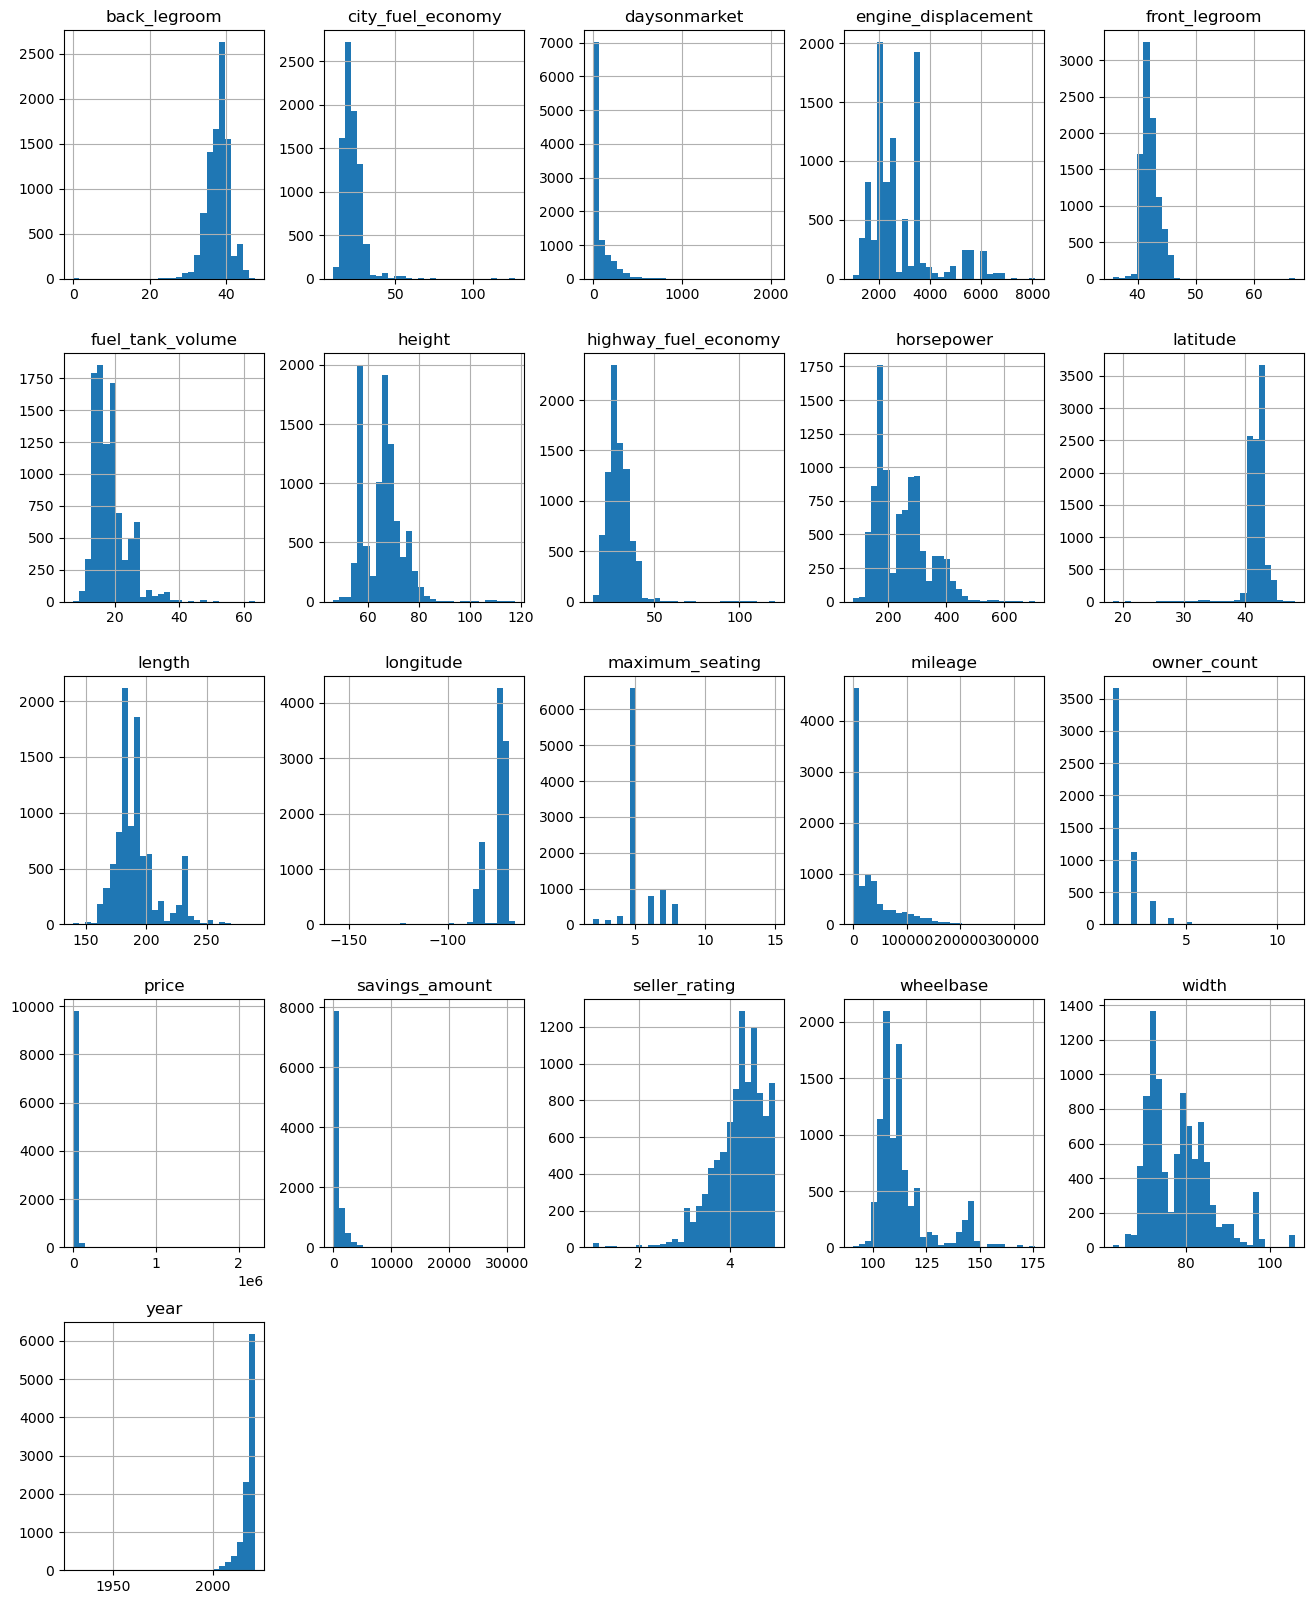

In [48]:
import matplotlib.pyplot as mpl
%matplotlib inline

df_numerical = df.select_dtypes(include=[np.int64, np.float64]).drop(columns=['listing_id', 'sp_id'])
df_numerical.hist(figsize=(16,20), bins=30)
mpl.show()

Observations:
- Both Fuel economy attributes appear to be normally distributed with a slight skew
- Majority of cars do not stay on the market for a long duration, mostly less than a couple of months. Some may be above a large amount so these may need to be removed to not skew data.
- Engine displacement doesn't appear to have any obvious standard distribution
- Horsepower appears to have a normal distribution around 200hp with a standard deviation of around 50hp
- Lattitude is as expected all grouped together around 39 to 44 
- longitutde is split into two peaks, most likely corresponding to central US and alaska
- Milegae of most cars is grouped mostly around 0 and fewer cars with higher mileage, as would be expected
- owner count has a modal of 1, again as to be expected
- Most cars prices are group around the same order of magnitutde. Howeever some extremes are seen. A logarithmic transformation may need to be considered later.
- Seller ratings appear to be skew negatively towards the higher end
- Majority of cars are from the last 15 years
- Modal max seats is 5

Now let's examine the qualatitative data.

In [49]:
df.select_dtypes(include=object).head(10)

,body_type,city,description,engine_cylinders,engine_type,exterior_color,fleet,frame_damaged,franchise_make,fuel_type,has_accidents,interior_color,isCab,listed_date,listing_color,main_picture_url,major_options,make_name,model_name,power,salvage,sp_name,theft_title,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display
0,Pickup Truck,Rochester Hills,[!@@Additional Info@@!]1-Year SiriusXM Radio S...,V6 Flex Fuel Vehicle,V6 Flex Fuel Vehicle,Bright White,NaN,NaN,RAM,Flex Fuel Vehicle,NaN,Black,NaN,2020-08-23,WHITE,https://static.cargurus.com/images/forsale/202...,"['Navigation System', 'Remote Start', 'Parking...",RAM,1500,"395 hp @ 5,600 RPM",NaN,Rochester Hills Chrysler Jeep Incorporated,NaN,"410 lb-ft @ 3,950 RPM",A,8-Speed Automatic,t86929,Big Horn Crew Cab 4WD,4WD,Four-Wheel Drive
1,SUV / Crossover,Auburn,2018 Nissan Rogue SV Brilliant Silver Rear Bac...,I4,I4,Brilliant Silver,False,False,Nissan,Gasoline,False,Black (Charcoal),False,2020-09-03,SILVER,https://static.cargurus.com/images/forsale/202...,"['Navigation System', 'Alloy Wheels', 'Bluetoo...",Nissan,Rogue,"170 hp @ 6,000 RPM",False,Bertera Nissan,False,"175 lb-ft @ 4,400 RPM",CVT,Continuously Variable Transmission,t76574,SV AWD,AWD,All-Wheel Drive
2,Sedan,Sacramento,"Vibrant in Nebula Gray Pearl, our One Owner No...",V6,V6,Nebula Gray Pearl,False,False,NaN,Gasoline,True,Black w/Piano Black,False,2020-06-26,GRAY,https://static.cargurus.com/images/forsale/202...,"['Sunroof/Moonroof', 'Adaptive Cruise Control'...",Lexus,ES 350,"268 hp @ 6,200 RPM",False,Car Expo Auto Center,False,"248 lb-ft @ 4,700 RPM",A,Automatic,t69510,350 FWD,FWD,Front-Wheel Drive
3,Minivan,Charlton,Visit Gary Jackson Motors online at www.garyja...,V6 Flex Fuel Vehicle,V6 Flex Fuel Vehicle,Gray,False,False,NaN,Flex Fuel Vehicle,False,Select,False,2020-09-09,GRAY,NaN,['Third Row Seating'],Dodge,Grand Caravan,"283 hp @ 6,400 RPM",False,Gary-Jackson Motors,False,"260 lb-ft @ 4,400 RPM",A,Automatic,t52716,American Value Package FWD,FWD,Front-Wheel Drive
4,SUV / Crossover,Everett,Crystal Black Pearl 2020 Honda CR-V LX AWD CVT...,I4,I4,Crystal Black Pearl,NaN,NaN,Honda,Gasoline,NaN,Black,NaN,2020-06-11,BLACK,https://static.cargurus.com/images/forsale/202...,"['Adaptive Cruise Control', 'Alloy Wheels', 'B...",Honda,CR-V,"190 hp @ 5,600 RPM",NaN,Honda Cars Of Boston,NaN,"179 lb-ft @ 2,000 RPM",CVT,Continuously Variable Transmission,t89601,LX AWD,AWD,All-Wheel Drive
5,SUV / Crossover,Long Island City,* 2018 ** Hyundai * * Tucson * * SEL * Outfit...,I4,I4,Black Noir Pearl,True,False,Hyundai,Gasoline,False,Black,True,2020-08-16,BLACK,https://static.cargurus.com/images/forsale/202...,"['Alloy Wheels', 'Bluetooth', 'Backup Camera',...",Hyundai,Tucson,"164 hp @ 6,200 RPM",False,Long Island City Hyundai,False,"151 lb-ft @ 4,000 RPM",A,Automatic,t77516,2.0L SEL AWD,AWD,All-Wheel Drive
6,Convertible,Walled Lake,SUPER RARE!!! RENNTECH PKG SOFTWARE TCU AND EC...,V12,V12,Black,False,False,NaN,Gasoline,False,Brown (Tan),False,2020-05-18,BLACK,https://www.autocorner.com/dealers/www.dmmotor...,"['Leather Seats', 'Sunroof/Moonroof', 'Navigat...",Mercedes-Benz,SL-Class,"604 hp @ 4,800 RPM",False,DM Motors LLC,False,"738 lb-ft @ 2,000 RPM",A,5-Speed Automatic,t33608,SL AMG 65,RWD,Rear-Wheel Drive
7,SUV / Crossover,Yorktown Heights,Brilliant Silver Metallic 2020 Nissan Rogue SV...,I4,I4,Brilliant Silver Metallic,NaN,NaN,Nissan,Gasoline,NaN,Black (Charcoal),NaN,2020-02-19,SILVER,https://d28oohqmlmgnr6.cloudfront.net/97/97/ab...,"['Alloy Wheels', 'Blind Spot Monitoring', 'Hea...",Nissan,Rogue,"170 hp @ 6,000 RPM",NaN,Nissan of Yorktown Heights,NaN,"175 lb-ft @ 4,400 RPM",CVT,Continuously Variable Transmission,t86700,SV AWD,AWD,All-Wheel Drive
8,SUV / Crossover,Lynnfield,BUY WITH CONFIDENCE The Herb Chambers Companie...,V8,V8,Crystal White Tricoat,NaN,NaN,Cadillac,Gasoline,NaN,Kona Brown,NaN,2019-08-23,WHITE,https://static.cargurus.com/images/forsale/202...,"['Leather Seats', 'Sunroof/Moonroof

Firstly, let's drop all the irrelevant meta data which won't be helpful with our model and will instead just increase the complexity which could lead to overfitting. For example the `description`, `interior color`, `exterior color` etc

In [50]:
df = df.drop(columns=['description', 'interior_color', 'exterior_color', 
                      'main_picture_url', 'model_name', 'sp_name', 'transmission_display',
                      'trim_name', 'trimId'])

Next, it is easy to see that `engine_cylinders` and `engine_type` appear to be duplicate. Similarly so do `wheel_system` and `wheel_system_display`, as well as `make_name` and `franchise_make`.

Before dropping one of each of these, the data will be further inspected to make sure that there's no discrepancy between the two in the wider data set (i.e. not just in the head).

In [51]:
df_engine = df[['engine_cylinders', 'engine_type']]
df_engine[np.logical_xor(df_engine.engine_cylinders.isna(), df_engine.engine_type.isna())].count()

engine_cylinders    0
engine_type         0
dtype: int64

So above tells us that all entries with attributes are identical in being either NA or not, so dropping one of these attributes means no information is lost.

In [52]:
df = df.drop(columns='engine_cylinders')

For the `wheel_system` and `wheel_system_display`:

In [53]:
df_wheel = df[['wheel_system', 'wheel_system_display']]
df_wheel[np.logical_xor(df_wheel.wheel_system.isna(), df_wheel.wheel_system_display.isna())].count()

wheel_system            0
wheel_system_display    0
dtype: int64

The above implies that both attributes provide the same information for the cars. Hence deciding which to drop is irrelevant. I will choose to drop the `wheel_system_display` since wheel system has a nice short appriviation.

In [54]:
df = df.drop(columns='wheel_system_display')

Finally for make.

In [55]:
df_make = df[['make_name', 'franchise_make']]
df_make[np.logical_xor(df_make.make_name.isna(), df_make.franchise_make.isna())].count()

make_name         2143
franchise_make       0
dtype: int64

From this we can see that the `make_name` has more information than the `franchise_make`, hence the `franchise_make` is dropped.

In [56]:
df = df.drop(columns='franchise_make')

In [57]:
df['transmission'].unique()

array(['A', 'CVT', nan, 'M', 'Dual Clutch'], dtype=object)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   back_legroom          9167 non-null   float64
 1   body_type             9958 non-null   object 
 2   city                  10000 non-null  object 
 3   city_fuel_economy     8360 non-null   float64
 4   daysonmarket          10000 non-null  int64  
 5   engine_displacement   9485 non-null   float64
 6   engine_type           9714 non-null   object 
 7   fleet                 5595 non-null   object 
 8   frame_damaged         5595 non-null   object 
 9   franchise_dealer      10000 non-null  bool   
 10  front_legroom         9453 non-null   float64
 11  fuel_tank_volume      9509 non-null   float64
 12  fuel_type             9762 non-null   object 
 13  has_accidents         5595 non-null   object 
 14  height                9512 non-null   float64
 15  highway_fuel_economy

## Explore correlations

Firstly let's explore the correlation between all the numerical attributes and the price

In [59]:
df_numerical = df.select_dtypes(include=[np.float64, np.int64])
# abs taken as don't care if posotive or negative effect
corr_series = abs(df_numerical.drop("price", axis=1).apply(lambda x: x.corr(df_numerical.price)))
corr_series

back_legroom            0.271285
city_fuel_economy       0.158765
daysonmarket            0.064113
engine_displacement     0.317525
front_legroom           0.046205
fuel_tank_volume        0.363563
height                  0.263123
highway_fuel_economy    0.225484
horsepower              0.611639
latitude                0.001402
length                  0.342174
listing_id              0.060968
longitude               0.042599
maximum_seating         0.128544
mileage                 0.333322
owner_count             0.286284
savings_amount          0.004000
seller_rating           0.046401
sp_id                   0.116458
wheelbase               0.347086
width                   0.396831
year                    0.235428
dtype: float64

Now let's choose all attributes with a correlation of more than 0.3 and use some of our contextual knowledge to inspect.

In [60]:
corr_series[corr_series > 0.3]

engine_displacement    0.317525
fuel_tank_volume       0.363563
horsepower             0.611639
length                 0.342174
mileage                0.333322
wheelbase              0.347086
width                  0.396831
dtype: float64

All these attributes seem to make logical sense. One attribute that could be removed is one of `wheelbase` or `length` since they represent different ways to measure the length of a car. Since wheelbase has the higher correlation, `length` will be dropped. Let's inspect the above attributes in more detail.

In [61]:
#df = df.drop(columns='length')
corr_series = corr_series.drop('length')
corr_series

back_legroom            0.271285
city_fuel_economy       0.158765
daysonmarket            0.064113
engine_displacement     0.317525
front_legroom           0.046205
fuel_tank_volume        0.363563
height                  0.263123
highway_fuel_economy    0.225484
horsepower              0.611639
latitude                0.001402
listing_id              0.060968
longitude               0.042599
maximum_seating         0.128544
mileage                 0.333322
owner_count             0.286284
savings_amount          0.004000
seller_rating           0.046401
sp_id                   0.116458
wheelbase               0.347086
width                   0.396831
year                    0.235428
dtype: float64

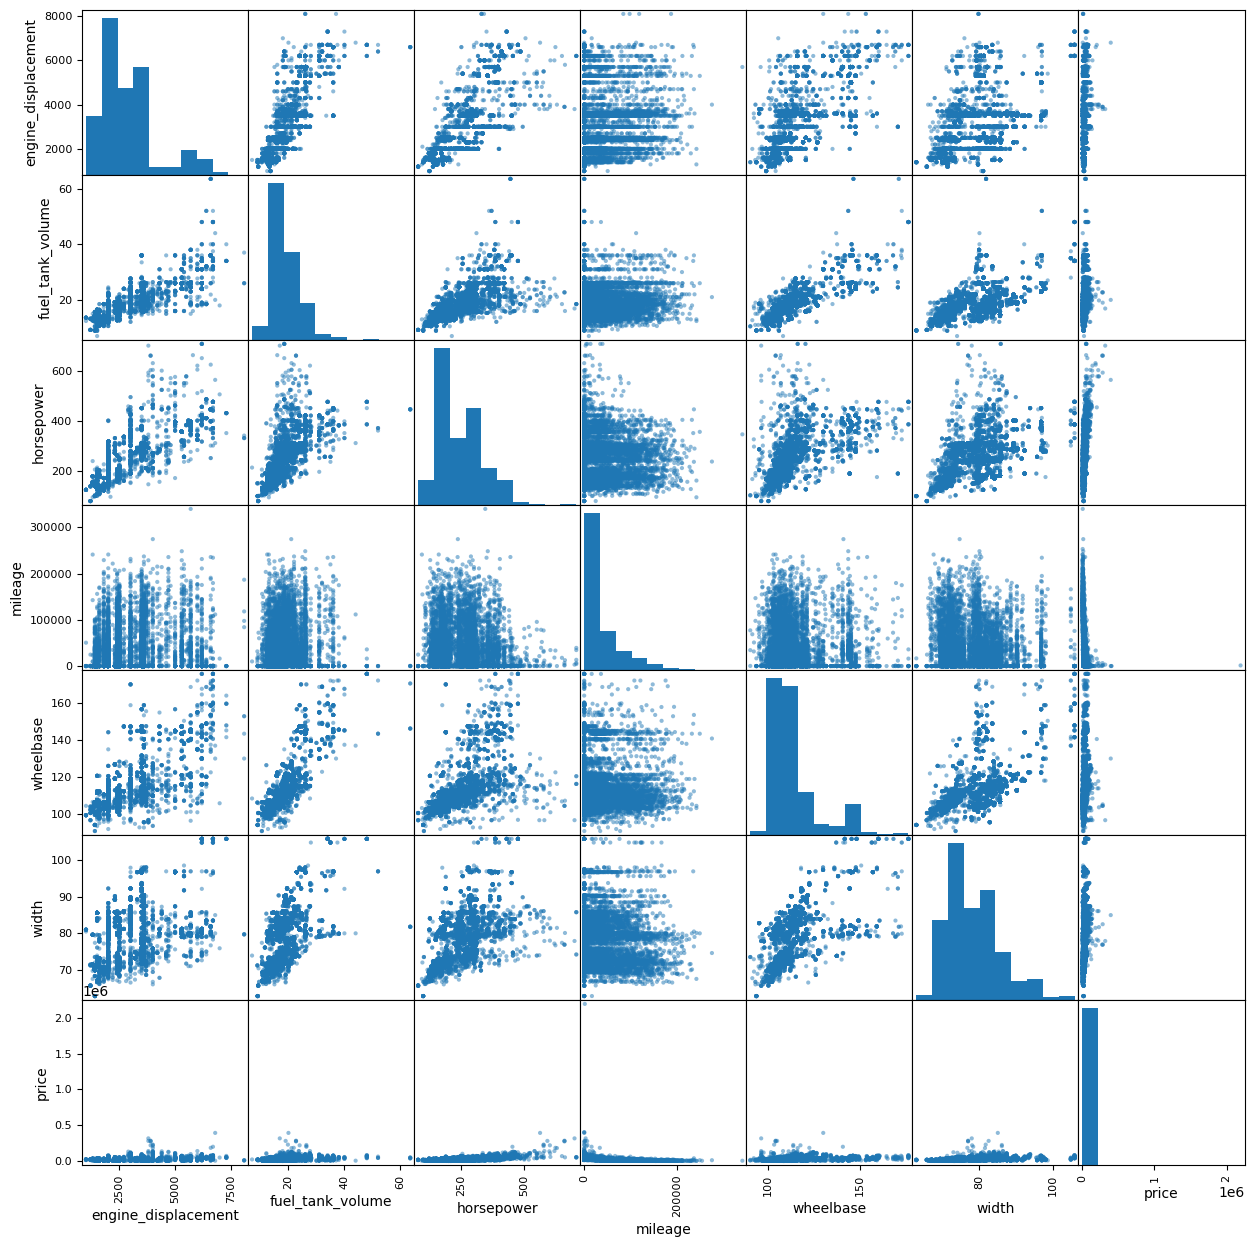

In [62]:
pd.plotting.scatter_matrix(df[corr_series[corr_series > 0.3].keys().to_list() + ['price']], figsize=(15,15))
mpl.show()

Inspecting the price row (or column), horsepower and mileage have the stongest correlation as to be expected. 
wheelbase and width appear to have similar correlation to price, which is to be expected by them being a measurement of size.

Next to check if the attributes chosen have NAs. Any attributes with entries that contain an NA will be shown below.

In [63]:
df.keys()[df.count() != len(df.index)]

Index(['back_legroom', 'body_type', 'city_fuel_economy', 'engine_displacement',
       'engine_type', 'fleet', 'frame_damaged', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'isCab', 'length',
       'major_options', 'maximum_seating', 'mileage', 'owner_count', 'power',
       'salvage', 'seller_rating', 'sp_id', 'theft_title', 'torque',
       'transmission', 'wheel_system', 'wheelbase', 'width'],
      dtype='object')

Clearly there is issues with some attributes. Let's first inspect the numerical attributes with NA issues.

In [66]:
df[df.select_dtypes(include=[np.int64, np.float64]).isnull().any(axis=1)].select_dtypes(include=[np.int64, np.float64]).isnull().any()

back_legroom             True
city_fuel_economy        True
daysonmarket            False
engine_displacement      True
front_legroom            True
fuel_tank_volume         True
height                   True
highway_fuel_economy     True
horsepower               True
latitude                False
length                   True
listing_id              False
longitude               False
maximum_seating          True
mileage                  True
owner_count              True
price                   False
savings_amount          False
seller_rating            True
sp_id                    True
wheelbase                True
width                    True
year                    False
dtype: bool

So we have an issue with engine_displacement, horsepower and owner_count. Let's see how severe this issue is.

In [26]:
df[['engine_displacement', 'horsepower', 'owner_count']].count(), data_original_length

(engine_displacement    9478
 horsepower             9478
 owner_count            5243
 dtype: int64,
 10000)

Clearly there is severe issues with 'owner_count'. Now this could be an important metric, however the 'mileage' attribute will likely be able to show similar information implicitly, but with likely more detail since it is a continuous not descrete attribute. Hence the owner_count will be ommitted.

In [27]:
df = df.drop(columns='owner_count')

For the horsepower attribute after further inspection into the data, it can be seen that the horsepower attribute is actually contained within the power attribute(see example below).

In [67]:
df.loc[1, ['horsepower', 'power']]

horsepower                 170.0
power         170 hp @ 6,000 RPM
Name: 1, dtype: object

Hence since we assign all the horspower values from the power column. 

There is also another useful attribute of RPM which could help to distinguish between performance cars with large horsepower and 4x4 with the same, but there may be too many NAs for this attribute to use this metric, let's see.

First let's see if there is enough attributes from either horsepower and power for each entry to get a car's horsepower.

In [68]:
df_no_hp = df[df['horsepower'].isna() & df['power'].isna()]

In [69]:
len(df_no_hp) / data_original_length

0.0515

So from above we can see that only around 5% have no power or horsepower attribute. For these remaining entries we will consider how many have engine size attributes.

In [70]:
df_no_hp_engine_size = df[df.engine_type.isna() & df.power.isna() & df.horsepower.isna()]
len(df_no_hp_engine_size) / len(df)

0.0212

Now there is only a small amount of cars with neither horsepower, power or engine_type attribute. All these entries will simply take the overall average for horsepower.

The horsepower for all cars will be assigned using the following:

- If the car has horspower asigned pass
- If the car has power but no horsepower, find horsepower from power
- If the car has neither assign the horsepower as the average of a car for the given engine_type
- If the car has none of these assign the overall average for horsepower

This will be done later in a pipeline when preparing the data

In [71]:
def get_power_data(s: str):
    """
    Returns the hp and RPM from the power string
    attribute of a vehicle
    """
    if not pd.isna(s):
        try:
            string_split: list = s.split(" ")
            return string_split[0], string_split[3].replace(",", "")
        except AttributeError:
            pass
    return np.nan, np.nan

# Example of usage
#zip(*map(get_power_data, df.engine_size))

In [73]:
df.horsepower = df[['horsepower', 'power', 'engine_size']].apply(lambda x: x['horsepower'] if not pd.isna(x['horsepower'])
                         else (x.power if not x.power.isna() else get_power_data(x.engine_size)[0]))

KeyError: "['engine_size'] not in index"

In [ ]:
df.loc[:, (df.count() / len(df.index)) < 0.95]
df.engine_size

As most a large amount of the attributes are categorical or boolean, changing the remaining NAs to the average of the column would not make much sense. Furthermore, since the dataset is very large, removing NAs is unlikely to heavily impact the model. However to make sure the one type of car or manufactor is not being discrimanted against before they're removed the entries with NAs will be inspected.

In [ ]:
car_makes_with_NA = df1[df1.isnull().any(axis=1)].make_name.unique()
df_prepared = df1[~df1.isnull().any(axis=1)]
car_makes_no_NA = df_prepared.make_name.unique()

(set(car_makes_no_NA) and set(car_makes_with_NA)) == set(car_makes_with_NA)

This means all car makes are being represented still even when NA rows are removed.

Now the data has been filtered, the exploration of relationships can begin. Note that only 4% of the entries have been removed.

In [ ]:
round(len(df_prepared.index) / data_original_length, 2)

In [ ]:
used_cars_prices = df_prepared["price"].copy()
used_cars_prices.head()

In [ ]:
# os.chdir(folder_path)
# file_names : list = [i for i in glob.glob("*.{}".format('csv'))]
# df = pd.concat(map(read_car_data, file_names))


## Choosing attributes

Inspecting this list and using our contextual knowledge of cars, as well as the info available on the [kaggle page](https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset). Certain attributes can be removed immediately, leaving ones that are believed to influence the price. Any attributes left will be further inspected before any models are used. 

Note: data types are now defined to make sure any further exploration is done correctly.

In [ ]:
# Attributes belived to influence price
desired_attributes : list = ["body_type", "city", "daysonmarket", "dealer_zip", "engine_cylinders", "engine_displacement",
                             "engine_type", "fleet", "frame_damaged", "franchise_dealer", "fuel_tank_volume", "has_accidents", "horsepower",
                            "is_new", "listed_date", "make_name", "owner_count", "power", "price",
                             "savings_amount", "seller_rating", "year", "torque"
                            ]
    
# REMOEVE ANY IRRELEVANT ONES
# Define datatypes of attributes to make sure any exploration is good.
data_types = {'vin' : str, 'back_legroom' : str, 'bed' : str, 'bed_height' : str,
              'bed_length' : str, 'body_type' : str, 'cabin' : str, 'city' : str,
              'city_fuel_economy' : np.float64, 'combine_fuel_economy' : np.float64,
              'daysonmarket' : np.int32, 'dealer_zip' : np.int32, 'description' : str, 
              'engine_cylinders' : str, 'engine_displacement' : np.float64,
              'engine_type' : str, 'exterior_color' : str, 'fleet' : bool, 'frame_damaged' : bool,
              'franchise_dealer' : bool, 'franchise_make' : str, 'front_legroom' : str,
              'fuel_tank_volume' : str, 'fuel_type' : str, 'has_accidents' : bool, 'height' : str,
            'highway_fuel_economy' : np.float64, 'horsepower' : np.float64, 'interior_color' : str, 'isCab' : bool,
            'is_certified' : bool, 'is_cpo' : bool, 'is_new' : bool, 'is_oemcpo' : bool, 'latitude' : np.float64, 'length' : str,
            'listed_date' : str, 'listing_color' : str, 'listing_id' : np.int32, 'longitude' : np.float64,
            'main_picture_url' : str, 'major_options' : str, 'make_name' : str, 'maximum_seating' : np.int32,
            'mileage' : np.int32, 'model_name' : str, 'owner_count' : np.int32, 'power' : str, 'price' : np.float64, 'salvage' : bool,
            'savings_amount' : np.int32 , 'seller_rating' : np.float64, 'sp_id' : np.int32, 'sp_name' : str, 'theft_title' : bool,
            'torque' : str, 'transmission' : str, 'transmission_display' : str, 'trimId' : np.int32, 'trim_name' : str,
            'vehicle_damage_category' : str, 'wheel_system' : str, 'wheel_system_display' : str,
            'wheelbase' : str, 'width' : str, 'year' : np.int32}

    
df = df[df.columns.intersection(desired_attributes)].convert_dtypes(data_types).copy()
df = df.reset_index(drop=True) # Let's also reset the index to stop using vin